In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm 

In [2]:
years = 15 

endDate = dt.datetime.now()

startDate = endDate - dt.timedelta(days = 365*years)

In [3]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']


In [4]:
#Download adjusted close prices

adj_close_df = pd.DataFrame()

for t in tickers:
    data = yf.download(t, start= startDate, end= endDate)
    adj_close_df[t] =  data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2008-10-08   72.975693  48.154274   89.419998   28.333387   36.723778
2008-10-09   67.879166  46.654327   89.900002   27.572340   34.417698
2008-10-10   66.232697  45.231915   83.220001   27.397387   33.422924
2008-10-13   75.849533  47.113346   81.989998   30.730217   37.711002
2008-10-14   74.726944  47.714630   82.199997   29.400589   37.386955
...                ...        ...         ...         ...         ...
2023-09-29  427.480011  69.587997  171.449997  358.269989  212.410004
2023-10-02  427.309998  69.110001  169.649994  361.260010  212.130005
2023-10-03  421.589996  68.550003  169.160004  354.920013  209.050003
2023-10-04  424.660004  69.000000  169.139999  359.750000  210.559998
2023-10-05  424.855011  69.099998  168.767700  359.739990  210.620102

[3774 rows x 5 columns]


In [6]:
#Calculate daily log returns and drop NA
#Drop NA as first row will be null

log_returns = np.log(adj_close_df/adj_close_df.shift(1))

log_returns = log_returns.dropna()

In [7]:
log_returns

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2008-10-09,-0.072397,-0.031644,0.005354,-0.027228,-0.064854
2008-10-10,-0.024555,-0.030963,-0.077210,-0.006365,-0.029329
2008-10-13,0.135577,0.040753,-0.014890,0.114799,0.120710
2008-10-14,-0.014911,0.012682,0.002558,-0.044232,-0.008630
2008-10-15,-0.103637,-0.006116,0.013413,-0.093824,-0.098197
...,...,...,...,...,...
2023-09-29,-0.002430,-0.000430,-0.010329,0.000726,-0.002915
2023-10-02,-0.000398,-0.006893,-0.010554,0.008311,-0.001319
2023-10-03,-0.013476,-0.008136,-0.002892,-0.017705,-0.014626


In [9]:
#Create equally weighted portfolio

port_val = 10000000
weights = np.array([1/len(tickers)] *len(tickers))
print(weights)

[0.2 0.2 0.2 0.2 0.2]


In [10]:
#Historical Portfolio Return 

hist_return = (log_returns*weights).sum(axis=1)

print(hist_return)

Date
2008-10-09   -0.038154
2008-10-10   -0.033684
2008-10-13    0.079390
2008-10-14   -0.010507
2008-10-15   -0.057672
                ...   
2023-09-29   -0.003075
2023-10-02   -0.002171
2023-10-03   -0.011367
2023-10-04    0.006879
2023-10-05   -0.000008
Length: 3773, dtype: float64


In [11]:
#Find X-Day historical return 

days = 5

historical_x_day_return = hist_return.rolling(window = days).sum()
historical_x_day_return = historical_x_day_return.dropna()
print(historical_x_day_return)

Date
2008-10-15   -0.060627
2008-10-16   -0.004663
2008-10-17    0.021963
2008-10-20   -0.027026
2008-10-21   -0.042360
                ...   
2023-09-29   -0.012486
2023-10-02   -0.014733
2023-10-03   -0.015407
2023-10-04   -0.006079
2023-10-05   -0.009742
Length: 3769, dtype: float64


In [12]:
cov_matrix = log_returns.cov() * 252
#annualised
cov_matrix

,SPY,BND,GLD,QQQ,VTI
SPY,0.040485,0.000153,0.002678,0.041632,0.040725
BND,0.000153,0.002628,0.002193,0.000101,0.000143
GLD,0.002678,0.002193,0.027817,0.002526,0.002870
QQQ,0.041632,0.000101,0.002526,0.049863,0.042129
VTI,0.040725,0.000143,0.002870,0.042129,0.041394


In [13]:
portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

portfolio_std_dev

0.13152800321197333

In [14]:
#Setting Confidence Level 

confidence_levels = [0.9,0.95,0.99]

In [17]:
#Calculate VaR at various levels

VaRs = []

for cl in confidence_levels:
    VaR = port_val * portfolio_std_dev * norm.ppf(cl) * np.sqrt(days/252)
    VaRs.append(VaR)

In [18]:
print(VaRs)

[237431.88706196746, 304740.5278786794, 431000.3440722965]


In [21]:
print(f'{"Confidence Level":<20} {"Value at Risk":<20} ')
print('-' * 40)

#Print each confidence level and it's corresponding VaR Value


for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>6.0f}%: {"":<8} ${VaR:>,.2f}')


Confidence Level     Value at Risk        
----------------------------------------
    90%:          $237,431.89
    95%:          $304,740.53
    99%:          $431,000.34


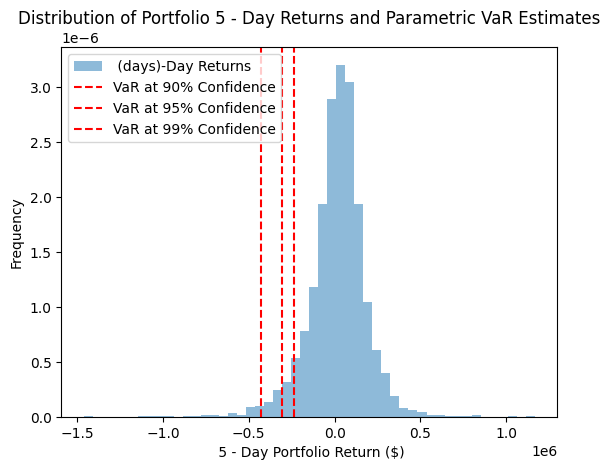

In [23]:
#Set labels title and legends
# Convert returns to dollar values for the histogram

historical_x_day_return_dollar = historical_x_day_return * port_val

# Plot the histogram

plt.hist(historical_x_day_return_dollar, bins=50, density=True, alpha=0.5, label=f' (days)-Day Returns')

# Add vertical lines representing VaR at each confidence level

for cl, VaR in zip (confidence_levels, VaRs):
    plt.axvline(x = -VaR, linestyle = '--', color = 'r', label = 'VaR at {}% Confidence'.format(int(cl * 100)))

plt.xlabel(f' {days} - Day Portfolio Return ($)')

plt.ylabel('Frequency')

plt.title(f'Distribution of Portfolio {days} - Day Returns and Parametric VaR Estimates')

plt.legend()

plt.show()


